In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, ReLU, LeakyReLU, MaxPooling2D, Lambda, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from keras import backend as K
from tensorflow.keras.models import Model

print(f"Tensorflow version : {tf.__version__}")

Tensorflow version : 2.13.0


In [ ]:
def create_pairs(x, digit_indices):
  '''Positice and negative pair creation.
   Altlernates between positive and negative pairs
  '''
  pairs = []
  labels = []
  n = min([len(digit_indices[d]) for d in range(10)]) - 1
  for d in range(10):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1,10)
      dn = (d + inc) % 10
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [0, 1]
    return np.array(pairs), np.array(labels)

In [ ]:
def create_pairs_on_set(images, labels):
  digit_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs, y = create_pairs(images, digit_indices)
  y = y.astype('float32')
  return pairs, y

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images / 255.
test_images = test_images / 255.

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4422102/4422102 [==============================] - 0s 0us/step


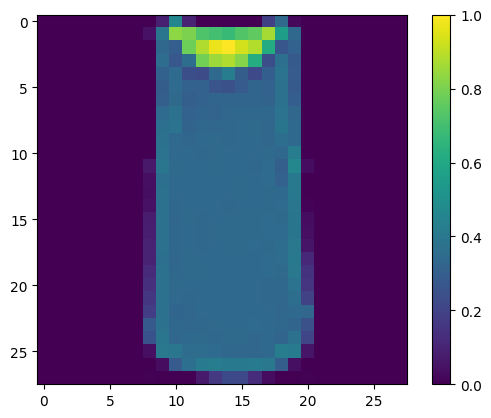

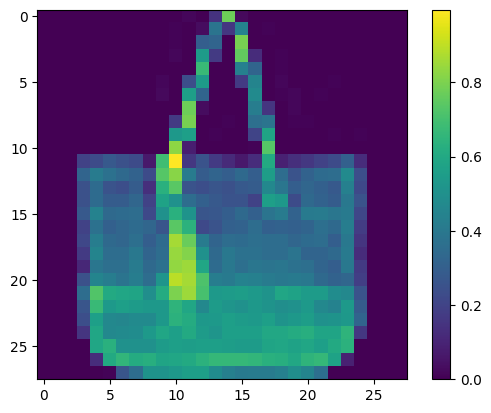

In [ ]:
def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

this_pair = 3
show_image(tr_pairs[this_pair][0]) # fed into left of network
show_image(tr_pairs[this_pair][1]) # fed into right of network

# pairs at even numbers are usually similar in this algorithm

In [ ]:
def initialize_base_network():
  input = Input(shape=(28,28,), name="base_input")
  x = Flatten(name="flatten_input")(input)
  x = Dense(128, activation="relu", name="first_base_dense")(x)
  x = Dropout(0.1, name="first_dropout")(x)
  x = Dense(128, activation="relu", name="second_base_dense")(x)
  x = Dropout(0.1, name="second_dropout")(x)
  x = Dense(128, activation="relu", name="third_base_dense")(x)
  return Model(inputs=input, outputs=x)

In [ ]:
# def initialize_base_network():
#   input = Input(shape=(28,28,1), name="base_input")
#   x = Conv2D(16, (3,3), padding='same', activation='relu',)(input)
#   x = MaxPooling2D((2,2), padding='same')(x)

#   x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
#   x = MaxPooling2D((2,2), padding='same')(x)

#   x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
#   x = Conv2D(16, (1,1), activation='relu')(x)
#   x = MaxPooling2D((2,2), padding='same')(x)
#   x = Dropout(0.5)(x)

#   x = Flatten()(x)
#   output = Dense(128, activation='relu')(x)
#   return Model(inputs=input, outputs=output)

In [ ]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

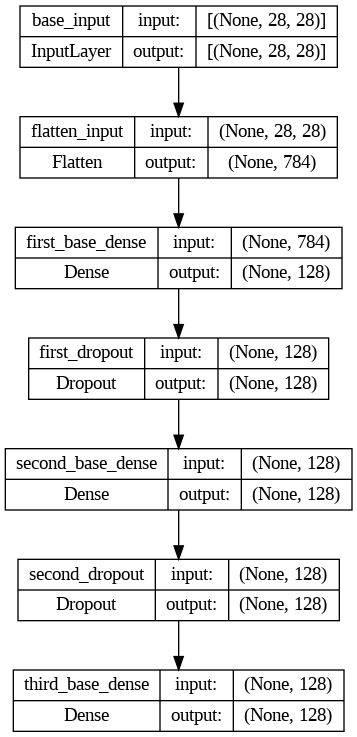

In [ ]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file="base-model.png")

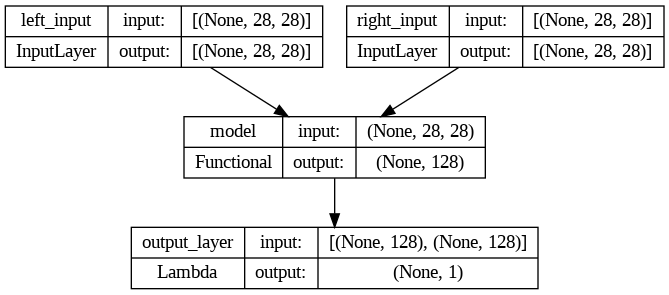

In [ ]:
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
model = Model(inputs=[input_a, input_b], outputs=output)

# plotting the model for visualisation
plot_model(model, show_shapes=True, show_layer_names=True, to_file="siamese-model.png")


In [ ]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-el-al'''
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin-y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [ ]:
rms = RMSprop()
adam = tf.keras.optimizers.Adam()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=adam)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]],
                    tr_y,
                    epochs=15,
                    batch_size=32,
                    validation_data=[[ts_pairs[:,0], ts_pairs[:,1]], ts_y])

loss = model.evaluate([ts_pairs[:,0], ts_pairs[:,1]], ts_y)

Epoch 1/15
375/375 [==============================] - 9s 8ms/step - loss: 0.2442 - val_loss: 0.2610
Epoch 2/15
375/375 [==============================] - 3s 7ms/step - loss: 0.2058 - val_loss: 0.2314
Epoch 3/15
375/375 [==============================] - 4s 9ms/step - loss: 0.1987 - val_loss: 0.2103
Epoch 4/15
375/375 [==============================] - 3s 7ms/step - loss: 0.1972 - val_loss: 0.2194
Epoch 5/15
375/375 [==============================] - 2s 7ms/step - loss: 0.1950 - val_loss: 0.2260
Epoch 6/15
375/375 [==============================] - 2s 5ms/step - loss: 0.1936 - val_loss: 0.2137
Epoch 7/15
375/375 [==============================] - 1s 4ms/step - loss: 0.1929 - val_loss: 0.2077
Epoch 8/15
375/375 [==============================] - 2s 5ms/step - loss: 0.1907 - val_loss: 0.2063
Epoch 9/15
375/375 [==============================] - 2s 5ms/step - loss: 0.1904 - val_loss: 0.2045
Epoch 10/15
375/375 [==============================] - 1s 4ms/step - loss: 0.1902 - val_loss: 0.2073

In [ ]:
def compute_accuracy(y_true, y_pred):
  '''Computes the calssification accuracy with fixed threshold of distances
  '''
  pred = y_pred.ravel() > 0.5
  return np.mean(pred == y_true)

In [ ]:
y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print(f"Loss = {loss},\nTrain accuracy = {train_accuracy},\nTest_accuracy = {test_accuracy}")

63/63 [==============================] - 0s 2ms/step
Loss = 0.19800342619419098,
Train accuracy = 0.1772795465910985,
Test_accuracy = 0.21171171171171171


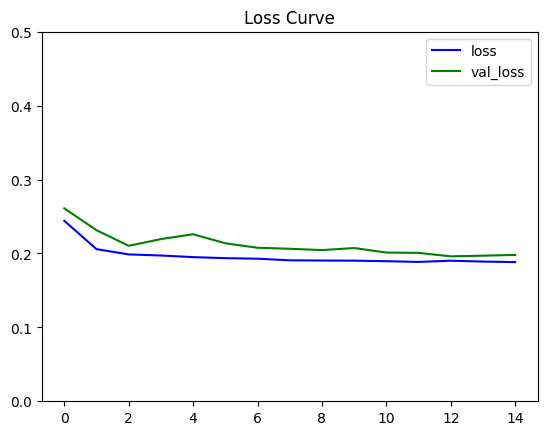

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name], color="blue", label=metric_name)
  plt.plot(history.history["val_"+metric_name], color="green", label="val_"+metric_name)
  plt.legend()
  plt.show()

plot_metrics(metric_name="loss", title="Loss Curve", ylim=0.5)

In [ ]:
def visualize_images():
  # Matplotlib config
  plt.rc('image', cmap="gray_r")
  plt.rc('grid', linewidth=0)
  plt.rc('xtick', top=False, bottom=False, labelsize='large')
  plt.rc('xtick', top=False, bottom=False, labelsize='large')
  plt.rc('axes', facecolor='F8F8F8', titlesize='large', edgecolor='white')
  plt.rc('text', color='a8151a')
  plt.rc('figure', facecolor='F0F0F0') # Matplotlib fonts

# utility to display row of digits with predictions
def display_images(left, right, predictions, labels, title, n):
  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  plt.grid(None)

  left = np.reshape(left, [n,28,28])
  left = np.swapaxes(left, 0, 1)
  left = np.reshape(left, [28, 28*n])
  plt.imshow(left)

  plt.figure(figsize=(17,3))
  plt.yticks([])
  plt.xticks([28*x + 14 for x in range(n)], predictions)
  for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] > 0.5: t.set_color('red') # bad prediction is red
  plt.grid(None)

  right = np.reshape(right, [n,28,28])
  right = np.swapaxes(right, 0, 1)
  right = np.reshape(right, [28, 28*n])
  plt.imshow(right)

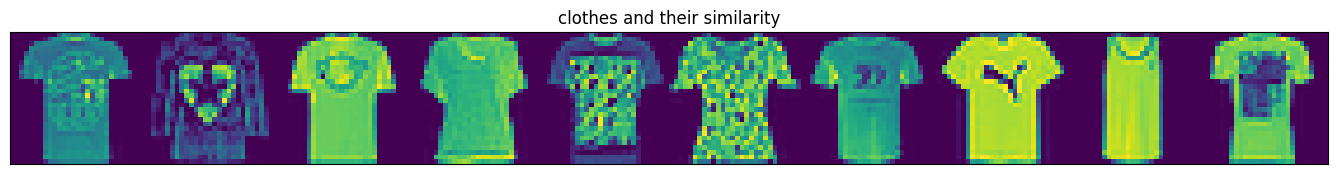

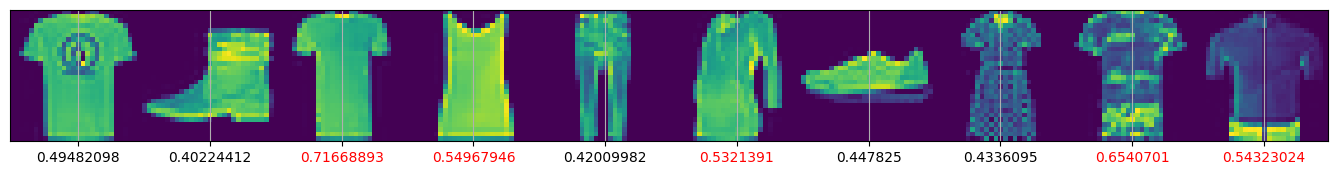

In [ ]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:,0][indexes], tr_pairs[:,1][indexes], y_pred_train[indexes], tr_y[indexes], 'clothes and their similarity', 10)